In [152]:
import math
import hashlib
from random import random
from scipy.stats import norm

def alpha_to_z(alpha, one_sided):
    if one_sided:
        pos = 1 - alpha
    else:
        pos = 1 - alpha/2.0
    return norm.ppf(pos)

def power_to_z(power):
    pos = power
    return norm.ppf(pos)

def z_to_p(z, one_sided):
    p = 1 - norm.cdf(z)
    if one_sided:
        return p
    else:
        return 2*p

def num_samples(alpha, mu_A, mu_delta, traffic_ratio_A, power=0.50, one_sided=True):
    z_alpha = alpha_to_z(alpha, one_sided)
    z_power  = power_to_z(power)
    mu_B = mu_A + mu_delta
    traffic_ratio_B = 1 - traffic_ratio_A
    N = ( mu_A*(1-mu_A)/traffic_ratio_A + mu_B*(1-mu_B)/traffic_ratio_B ) * ((z_alpha+z_power)**2) / (mu_A - mu_B)**2  
    return math.ceil(N)

def funnel_user(base_traffic_split, test_seed, user_id):
    test_id = hashlib.md5(test_seed.encode('ascii') + str(user_id).encode('ascii')).hexdigest()
    bits = bin(int(test_id, 16))[3:]
    r = sum([int(bit)*(0.5**(i+1)) for i, bit in enumerate(bits)])
    if r < base_traffic_split:
        return 'A'
    else:
        return 'B'

def run_test(N, hidden_conversion_params, funnel_user_func):
    test_outcomes = {'A': {'N': 0, 'conversions': 0}, 'B': {'N': 0, 'conversions': 0}}
    for user_id in range(N):
        which_funnel = funnel_user_func(user_id) # returns 'A' or 'B'
        test_outcomes[which_funnel]['N'] += 1
        if random() < hidden_conversion_params[which_funnel]:
            test_outcomes[which_funnel]['conversions'] += 1
    return test_outcomes

def p_value(N_A, mu_A, N_B, mu_B, one_sided=True):
    sigma_A_squared = mu_A * (1 - mu_A) / N_A
    sigma_B_squared = mu_B * (1 - mu_B) / N_B
    sigma_squared = sigma_A_squared + sigma_B_squared
    z = (mu_B - mu_A) / math.sqrt(sigma_squared)
    p = z_to_p(z, one_sided)
    return p

alpha = 0.10
power = 0.80
base_conversion = 0.10
valuable_diff = 0.01
base_traffic_split = 0.8

N_required = num_samples(
    alpha=alpha,
    mu_A=base_conversion,
    mu_delta=valuable_diff,
    traffic_ratio_A=base_traffic_split,
    power=power,
)
N_actual = 2 * N_required # because eg. we run it for a whole week

# hidden_conversion_params is how our funnels actually perform:
# the difference between the two is what we're trying to establish
# with statistical confidence, using an A/B test
hidden_conversion_params = {'A': 0.105, 'B': 0.115 }
test_seed = 'OkMdZa18pfr8m5sy2IL52pW9ol2EpLekgakJAIZFBbgZ'
test_outcomes = run_test(
    N_actual,
    hidden_conversion_params,
    lambda user_id: funnel_user(base_traffic_split, test_seed, user_id),
)

print(test_outcomes)

mu_A = test_outcomes['A']['conversions'] / test_outcomes['A']['N']
mu_B = test_outcomes['B']['conversions'] / test_outcomes['B']['N']

print('Measured conversion for A: %.3f' % mu_A)
print('Measured conversion for B: %.3f' % mu_B)
p = p_value(test_outcomes['A']['N'], mu_A, test_outcomes['B']['N'], mu_B)
print('p-value: %.3f' % p)
if p <= alpha:
    print("""Action: B is better, deploy""")
else:
    print("""Action: We're not sure if B is better than A""")

{'A': {'N': 43464, 'conversions': 4620}, 'B': {'N': 10812, 'conversions': 1222}}
Measured conversion for A: 0.106
Measured conversion for B: 0.113
p-value: 0.023
Action: B is better, deploy


In [153]:
# perform calibration test for type I error
# let's run the same A/B test, but set the hidden
# params so that A and B actually convert at the same rate
# we should still get a hit (ie. p < alpha)
# in alpha ratio of cases, but this is an error
# a so-called Type I error, ie. false positive rate

num_tests = 1000
alpha = 0.10
base_conversion = 0.10
valuable_diff = 0.01
base_traffic_split = 0.8
hidden_conversion_params = {'A': 0.10, 'B': 0.10 }
N = num_samples(
    alpha=alpha,
    mu_A=base_conversion,
    mu_delta=valuable_diff,
    traffic_ratio_A=base_traffic_split,
)

# get rid of this of the hashing, it's slow, we don't need it for a simulation
def funnel_user(base_traffic_split):
    if random() < base_traffic_split:
        return 'A'
    else:
        return 'B'

def run_tests(num_tests, N, alpha, hidden_conversion_params, funnel_user_func):
    num_successes = 0
    for i in range(num_tests):
        test_outcomes = run_test(
            N,
            hidden_conversion_params,
            funnel_user_func,
        )
        mu_A = test_outcomes['A']['conversions'] / test_outcomes['A']['N']
        mu_B = test_outcomes['B']['conversions'] / test_outcomes['B']['N']
        p = p_value(test_outcomes['A']['N'], mu_A, test_outcomes['B']['N'], mu_B)
        if p <= alpha:
            num_successes += 1
    return num_successes

num_successes = run_tests(
    num_tests,
    N,
    alpha,
    hidden_conversion_params,
    lambda _: funnel_user(base_traffic_split),
)

fpr = num_successes/num_tests
print("False Positive Rate = %.2f (expected = %.2f)" % (fpr, alpha))

False Positive Rate = 0.10 (expected = 0.10)


In [154]:
# measure the power: when actually B is better than A
# what percent of cases does the test find it?

num_tests = 1000
alpha = 0.10
power = 0.80
base_conversion = 0.10
valuable_diff = 0.01
base_traffic_split = 0.8
hidden_conversion_params = {'A': 0.10, 'B': 0.11 }
N = num_samples(
    alpha=alpha,
    power=power,
    mu_A=base_conversion,
    mu_delta=valuable_diff,
    traffic_ratio_A=base_traffic_split,
)

num_successes = run_tests(
    num_tests,
    N,
    alpha,
    hidden_conversion_params,
    lambda _: funnel_user(base_traffic_split),
)

tpr = num_successes/num_tests
print("True Positive Rate: %.2f (expected = %.2f)" % (tpr, power))

True Positive Rate: 0.79 (expected = 0.80)


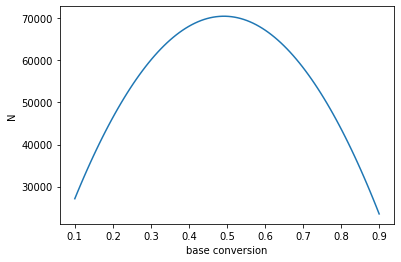

In [155]:
from numpy import linspace
import matplotlib.pyplot as plt

alpha = 0.10
power = 0.80
valuable_diff = 0.01
base_traffic_split = 0.8
data = []
for base_conversion in linspace(0.1, 0.9, 100):
    N = num_samples(
        alpha=alpha,
        power=power,
        mu_A=base_conversion,
        mu_delta=valuable_diff,
        traffic_ratio_A=base_traffic_split,
    )
    data.append((base_conversion, N))

plt.xlabel('base conversion')
plt.ylabel('N')
plt.plot([x[0] for x in data], [x[1] for x in data])
plt.show()

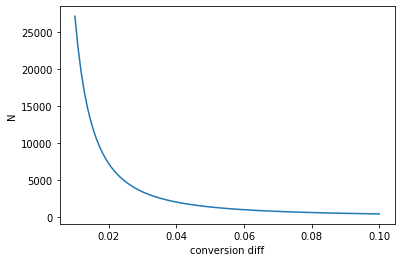

In [156]:
alpha = 0.10
power = 0.80
base_conversion = 0.10
base_traffic_split = 0.8
data = []
for valuable_diff in linspace(0.01, 0.10, 100):
    N = num_samples(
        alpha=alpha,
        power=power,
        mu_A=base_conversion,
        mu_delta=valuable_diff,
        traffic_ratio_A=base_traffic_split,
    )
    data.append((valuable_diff, N))

plt.xlabel('conversion diff')
plt.ylabel('N')
plt.plot([x[0] for x in data], [x[1] for x in data])
plt.show()

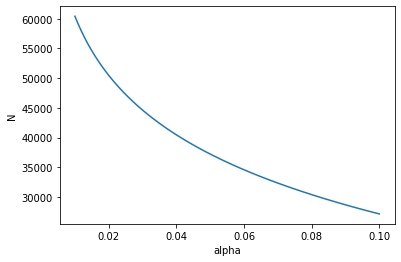

In [157]:
power = 0.80
base_conversion = 0.10
valuable_diff = 0.01
base_traffic_split = 0.8
data = []
for alpha in linspace(0.01, 0.10, 100):
    N = num_samples(
        alpha=alpha,
        power=power,
        mu_A=base_conversion,
        mu_delta=valuable_diff,
        traffic_ratio_A=base_traffic_split,
    )
    data.append((alpha, N))

plt.xlabel('alpha')
plt.ylabel('N')
plt.plot([x[0] for x in data], [x[1] for x in data])
plt.show()

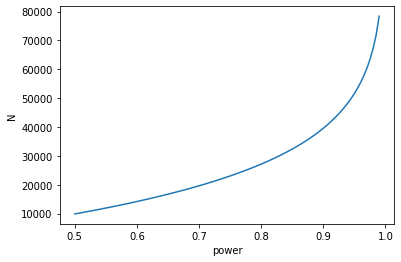

In [158]:
alpha = 0.10
base_conversion = 0.10
valuable_diff = 0.01
base_traffic_split = 0.8
data = []
for power in linspace(0.50, 0.99, 100):
    N = num_samples(
        alpha=alpha,
        power=power,
        mu_A=base_conversion,
        mu_delta=valuable_diff,
        traffic_ratio_A=base_traffic_split,
    )
    data.append((power, N))

plt.xlabel('power')
plt.ylabel('N')
plt.plot([x[0] for x in data], [x[1] for x in data])
plt.show()

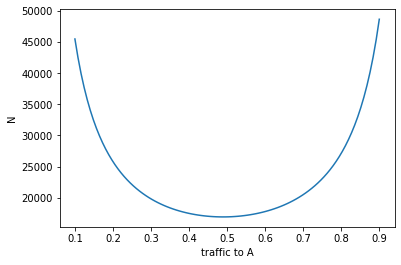

In [159]:
alpha = 0.10
power = 0.80
base_conversion = 0.10
valuable_diff = 0.01
data = []
for base_traffic_split in linspace(0.10, 0.90, 100):
    N = num_samples(
        alpha=alpha,
        power=power,
        mu_A=base_conversion,
        mu_delta=valuable_diff,
        traffic_ratio_A=base_traffic_split,
    )
    data.append((base_traffic_split, N))

plt.xlabel('traffic to A')
plt.ylabel('N')
plt.plot([x[0] for x in data], [x[1] for x in data])
plt.show()